In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# !pip install cartopy
# import cartopy
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pickle

# Load the pkl file
with open('PNA_region.pkl', 'rb') as file:
    data = pickle.load(file)


print(data['PC dimension'])
print(data['EOF dimension'])

PC  = data['PC']
EOF = data['EOF']
lat = data['lat']
lon = data['lon']



10 ensembles, 20 years, 12 months, 8 initialization (for each month), 47 lead time, 10 modes
10 modes, 20<lat<80, 100<lon<300


In [ ]:
# prepare coordinate
lat_dim, lon_dim  = np.where((lon>100)&(lon<300) & (lat>20)&(lat<80))
x                 = lon[lat_dim.min():lat_dim.max()+1,lon_dim.min():lon_dim.max()+1]
y                 = lat[lat_dim.min():lat_dim.max()+1,lon_dim.min():lon_dim.max()+1]

# visualize data 

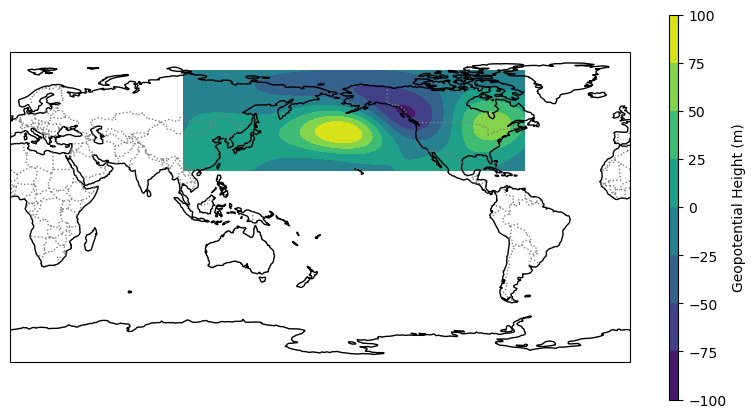

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the map projection and the plot
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Add coastlines and optional features
ax.coastlines()  # Adds the coastline
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  # Optional: adds country borders
# ax.add_feature(cfeature.LAND, color='lightgray')  # Optional: fills land areas
# ax.add_feature(cfeature.OCEAN, color='lightblue')  # Optional: fills ocean areas
sc = ax.contourf(x-180,y,EOF[1,:,:])

# Set the extent (longitude, latitude) of the plot
ax.set_extent([-180, 180, -90, 90])  # Adjust as needed for your area
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05, aspect=40)
cbar.set_label('Geopotential Height (m)')



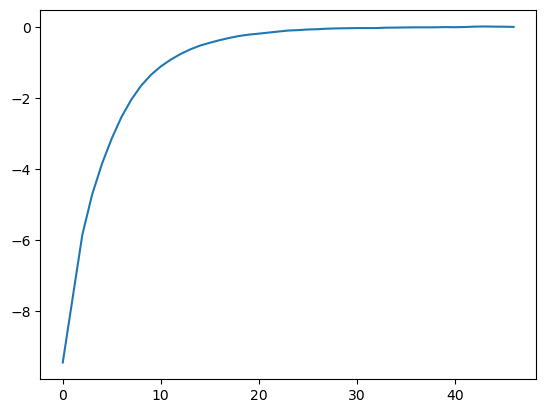

In [14]:
## error growth

## autocorrelation test
mode         = 1

dim          = PC[...,mode].shape
realizations = PC[...,mode].size
tmp          = PC[...,mode].reshape([int(realizations/dim[-1]),dim[-1]])

plt.figure()
series = np.mean(np.var(PC,axis=0)[:,:,:,:,mode],axis=(0,1,2)) # calculate ensemble variance
plt.plot(np.log(series/np.mean(series[30:])))



# Calculate predictable component 
## Step 1: Calculate the area between gray line and curve 
![image info](./APT_Schm.png)

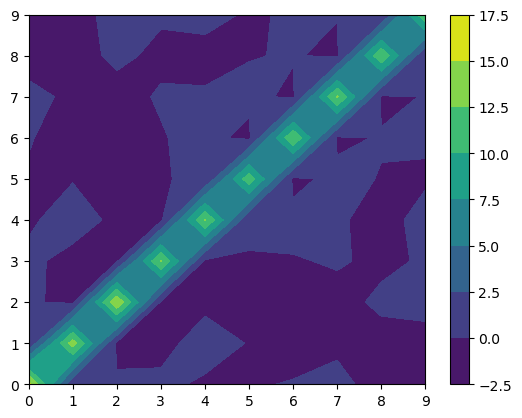

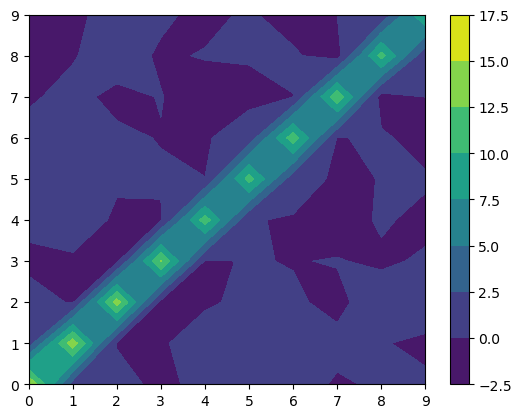

In [18]:
## predictable component analysis


# PC has dimension of ens, year, month, lead, PC modes
# using lag 30-47 to define climatology
# month            = [0,1,2,3,4,5,6,7,8,9,10,11]
mode             = 10
month            = [0,1,10,11]  # only use Nov-Feb data      
PC_winter        = PC[:,:,month,:,:]
dim_PC           = np.shape(PC[:,:,month,:,:])
sigma            = np.zeros((47,mode,mode))


# you can use matrix operation instead (which will be much faster)!!!
for i in range(dim_PC[4]): # loop over all reduced dimensions
    count = 0
    for year_idx in range(dim_PC[1]): # loop over year
        for month_idx in range(dim_PC[2]): # loop over month
            for init_inx in range(dim_PC[3]): # loop over initializations
                # subtract ensemble mean and calculate the ensemble variance (i.e., curve)
                tmp              = np.reshape(PC_winter[:,year_idx,month_idx,init_inx,i,:]-np.mean(PC_winter[:,year_idx,month_idx,init_inx,i,:], axis=0,keepdims=True),[dim_PC[0],mode])
                sigma[i,:,:]     = (tmp.T.dot(tmp)+sigma[i,:,:]*count)/(count+1)
                count            = count+1


# using the last 5-days to define climatology
sigma_inf = sigma[42:47,:,:].mean(axis=0)


plt.figure()
cs=plt.contourf(sigma_inf)
plt.colorbar(cs)

cov_diff     = np.zeros((mode,mode))
for i in range(dim_PC[4]):
    cov_diff = ((sigma_inf-sigma[i,:,:]).dot(np.linalg.inv(sigma_inf))+cov_diff)
plt.figure()
cs=plt.contourf(cov_diff)
plt.colorbar(cs)

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(cov_diff)
idx                       = eigenvalues.argsort()[::-1]
eigenvalues               = eigenvalues[idx]
eigenvectors              = eigenvectors[:,idx]
eigenvalues*2

array([34.44903878, 29.99518254, 25.8897357 , 25.23738306, 24.80906639,
       24.35043355, 21.04292533, 20.85989344, 19.80615066, 18.33728735])

<Figure size 640x480 with 0 Axes>

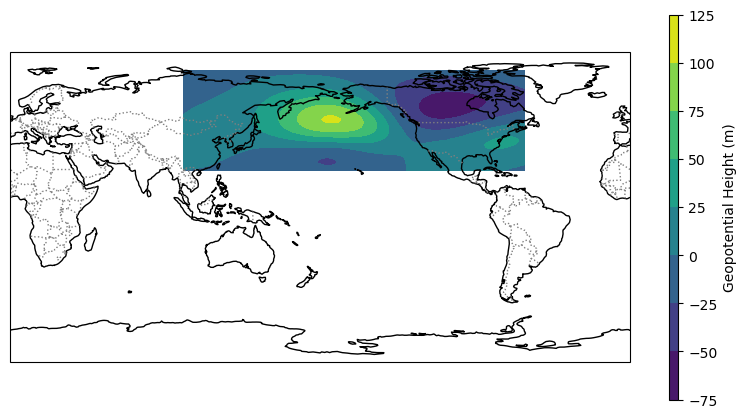

In [17]:
APTM1 = np.matrix(eigenvectors[:,0]).dot(EOF.reshape([10,40*133]))
APTM1 = APTM1.reshape([40,133])
plt.figure()
# Set up the map projection and the plot
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Add coastlines and optional features
ax.coastlines()  # Adds the coastline
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  # Optional: adds country borders
# ax.add_feature(cfeature.LAND, color='lightgray')  # Optional: fills land areas
# ax.add_feature(cfeature.OCEAN, color='lightblue')  # Optional: fills ocean areas
sc = ax.contourf(x-180,y,APTM1)

# Set the extent (longitude, latitude) of the plot
ax.set_extent([-180, 180, -90, 90])  # Adjust as needed for your area
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05, aspect=40)
cbar.set_label('Geopotential Height (m)')

